In [1]:
import numpy as np
import mpmath as mp
import math
import matplotlib as mpl
import scipy as sc
from matplotlib import pyplot as plt
#Constantes universales
h=4.13566773e-15
hbar=h/(2*np.pi)
kB=8.617333262e-5
m=3.817545e-26
w=2*np.pi*100
n0=1e7
t0=100e-6

In [2]:
def newtonraphson_1var(x1,x2,dx,tol,MAX,n,t):
    def f(x):
        F = -((kB**3)*(t**3))/((hbar**3)*(w**3))*mp.polylog(3,-mp.exp(x))-n
        return F
    def df(x): #Derivadad de la función
        der = -((kB**3)*(t**3))/((hbar**3)*(w**3))*mp.polylog(2,-mp.exp(x))
        return der
    while x1<x2:
        f_n=f(x1)
        f_np1=f(x1+dx)
        bracket=f_n*f_np1
        if bracket<0:
            x_n=x1
            step=1
            while True:
                x_nm1=x_n
                x_np1=x_n-(f(x_n)/df(x_n))
                x_n=x_np1
                step+=1
                if abs(x_n-x_nm1)<tol or step==MAX:
                    break
            return x_n*kB*t
        x1=x1+dx

In [3]:
evap_cool={'N':[],'T':[],'E':[],'Mu':[],'Q':[]}
mu_0=newtonraphson_1var(-16,-12,0.00001,0.0000001,10000,n0,t0)
e_0=3*n0*kB*t0*(mp.polylog(4,-mp.exp(mu_0/(kB*t0)))/mp.polylog(3,-mp.exp(mu_0/(kB*t0))))

In [4]:
print(mu_0)
print(e_0)

-1.18189362113555e-7
0.258520015720448


In [28]:
evap_cool['N'].append(n0)
evap_cool['T'].append(t0)
evap_cool['Mu'].append(mu_0)
evap_cool['E'].append(e_0)

In [29]:
qc=1.2283E-16-0.5E-16
dqc=0.01e-16
for i in range(0,200):
    evap_cool['Q'].append(qc-i*dqc)

In [7]:
def newtonraphson_2var(x1,x2,y1,y2,dx,dy,TOL,Ni,Ei):
    def f(Ti,mui):
        F=-((kB**3)*(Ti**3))/((hbar**3)*(w**3))*mp.polylog(3,-mp.exp(mui/(kB*Ti)))-Ni
        return F
    def g(Ti,mui):
        G=3*Ni*kB*Ti*(mp.polylog(4,-mp.exp(mui/(kB*Ti)))/mp.polylog(3,-mp.exp(mui/(kB*Ti))))-Ei
        return G
    def f_y(Ti,mui):
        F_mui=-((kB**2)*(Ti**2))/((hbar**3)*(w**3))*mp.polylog(2,-mp.exp(mui/(kB*Ti)))
        return F_mui
    def f_x(Ti,mui):
        F_Ti= -(3*(kB**3)*(Ti**2))/((hbar**3)*(w**3))*mp.polylog(3,-mp.exp(mui/(kB*Ti)))+(mui*(kB**2)*(Ti))/((hbar**3)*(w**3))*mp.polylog(2,-mp.exp(mui/(kB*Ti)))
        return F_Ti
    def g_y(Ti,mui):
        G_mui=3*Ni*(1-mp.polylog(4,-mp.exp(mui/(kB*Ti)))*mp.polylog(2,-mp.exp(mui/(kB*Ti)))/(mp.polylog(3,-mp.exp(mui/(kB*Ti)))**2))
        return G_mui
    def g_x(Ti,mui):
        G_Ti=3*Ni*(kB*mp.polylog(4,-mp.exp(mui/(kB*Ti)))/mp.polylog(3,-mp.exp(mui/(kB*Ti)))+(mui/Ti)*mp.polylog(4,-mp.exp(mui/(kB*Ti)))*mp.polylog(2,-mp.exp(mui/(kB*Ti)))/(mp.polylog(3,-mp.exp(mui/(kB*Ti)))**2)-(mui/Ti))
        return G_Ti
    
    while x1 > x2 and y1< y2:
        f_n = f(x1,y1)
        f_np1 = f(x1+dx,y1+dy)
        bracketF = f_n*f_np1        
        if bracketF < 0.0:
            x_n=x1
            y_n=y1
            step=1
            
            while True:
                x_nm1=x_n
                y_nm1=y_n
        
                x_np1= x_n + ((f_y(x_n,y_n)*g(x_n,y_n)-f(x_n,y_n)*g_y(x_n,y_n))/(f_x(x_n,y_n)*g_y(x_n,y_n)- f_y(x_n,y_n)*g_x(x_n,y_n)))
                y_np1= y_n + ((f(x_n,y_n)*g_x(x_n,y_n)-f_x(x_n,y_n)*g(x_n,y_n))/(f_x(x_n,y_n)*g_y(x_n,y_n)- f_y(x_n,y_n)*g_x(x_n,y_n)))
                x_n = x_np1
                y_n= y_np1
                step += 1
                
                if abs(x_n-x_nm1) < TOL and abs(y_n-y_nm1) < TOL:
                    break 
            resultado=[x_n,y_n]
            return resultado
        x1=x1-dx
        y1=y1+dy

In [8]:
def n_regresivo(Ni,Ti,Mui,qc):
    g3t=-mp.polylog(3,-mp.exp(Mui/(kB*Ti))*math.erf(mp.sqrt((qc**2)/(2*m*kB*Ti))))
    g3=-mp.polylog(3,-mp.exp(Mui/(kB*Ti)))
    g52b=-mp.polylog(5/2,-mp.exp(Mui/(kB*Ti) - (qc**2)/(2*m*kB*Ti)))
    etac=(qc**2)/(2*m*kB*Ti)
    N1= (g3t/g3 - (2/np.sqrt(mp.pi))*np.sqrt(etac)*(g52b/g3))*Ni
    return N1

def e_regresivo(Ni,Ti,Mui,Ei,qc):
    g52b=-mp.polylog(5/2,-mp.exp(Mui/(kB*Ti) - (qc**2)/(2*m*kB*Ti)))
    g4=-mp.polylog(4,-mp.exp(Mui/(kB*Ti)))
    g4t=-mp.polylog(4,-mp.exp(Mui/(kB*Ti))*math.erf(mp.sqrt((qc**2)/(2*m*kB*Ti))))
    g72b=-mp.polylog(7/2,-mp.exp(Mui/(kB*Ti) - (qc**2)/(2*m*kB*Ti)))
    etac=(qc**2)/(2*m*kB*Ti)
    
    E1= (g4t/g4 - (2/mp.sqrt(np.pi))*mp.sqrt(etac)*(g72b/g4) - (2/(3*mp.sqrt(np.pi)))*(etac**(3/2))*(g52b/g4))*Ei
    return E1

In [30]:
for i in range(0,199):
    evap_cool['N'].append(n_regresivo(evap_cool['N'][i-1],evap_cool['T'][i-1],evap_cool['Mu'][i-1],evap_cool['Q'][i-1]))
    evap_cool['E'].append(e_regresivo(evap_cool['N'][i-1],evap_cool['T'][i-1],evap_cool['Mu'][i-1],evap_cool['E'][i-1],evap_cool['Q'][i-1]))
    ti_mui=newtonraphson_2var(evap_cool['T'][i-1],1e-9,evap_cool['Mu'][i-1],-0.1e-15,1e-12,1e-20,1e-12,evap_cool['N'][i],evap_cool['E'][i])
    evap_cool['T'].append(ti_mui[0])
    evap_cool['Mu'].append(ti_mui[1])
    #print(evap_cool['N'][i],evap_cool['E'][i],evap_cool['T'][i],evap_cool['Mu'][i])

In [31]:
for i in range(0,200):
    print(evap_cool['N'][i],evap_cool['E'][i],evap_cool['T'][i],evap_cool['Mu'][i])

10000000.0 0.258520015720448 0.0001 -1.18189362113555e-7
9999999.99824092 0.258520015315494 0.0001 -1.18189362113555e-7
9989303.29756994 0.257541592055737 9.99999998609477e-5 -1.18189361914778e-7
9986836.41157731 0.257340743806078 9.97282050989307e-5 -1.17807158173498e-7
9973172.56562199 0.256130310457394 9.96750453571255e-5 -1.17732743740138e-7
9967487.23185336 0.255680752349855 9.93421301257059e-5 -1.17265314891896e-7
9949690.97171193 0.254163951670868 9.92243295914871e-5 -1.17100700900535e-7
9939574.63482582 0.253389928633872 9.88121132371535e-5 -1.16523091121281e-7
9916153.83850894 0.25147905629079 9.86114569338166e-5 -1.16243292821869e-7
9900096.44839883 0.250294258140182 9.80989572407493e-5 -1.15526953736904e-7
9869221.17689511 0.247891896135445 9.77951429426684e-5 -1.15104401839416e-7
9845426.68699159 0.246204288269199 9.71595000768503e-5 -1.14218614306154e-7
9804953.51240963 0.243209673799411 9.67312709746115e-5 -1.13624857290501e-7
9771398.45489422 0.240929425180839 9.59491494

In [26]:
evap_cool['N'].clear()
evap_cool['T'].clear()
evap_cool['E'].clear()
evap_cool['Mu'].clear()

In [27]:
evap_cool['Q'].clear()

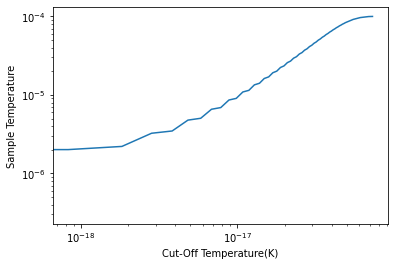

In [33]:
plt.figure()
plt.xlabel('Cut-Off Temperature(K)')
plt.ylabel('Sample Temperature')
plt.xscale('log')
plt.yscale('log')
plt.plot(evap_cool['Q'][0:200],evap_cool['T'])

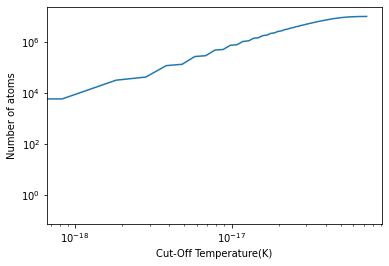

In [34]:
plt.figure()
plt.xlabel('Cut-Off Temperature(K)')
plt.ylabel('Number of atoms')
plt.xscale('log')
plt.yscale('log')
plt.plot(evap_cool['Q'][0:200],evap_cool['N'])

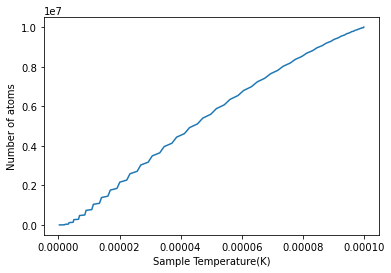

In [35]:
plt.figure()
plt.xlabel('Sample Temperature(K)')
plt.ylabel('Number of atoms')
#plt.xscale('log')
#plt.yscale('log')
plt.plot(evap_cool['T'][0:200],evap_cool['N'])